# Log File Outlier Detection

**Company Use Case:**

Due to the potential presence of sensitive patient data, log files cannot be shared or processed on the cloud directly. Homomorphic encryption comes into play by encrypting the log files and enabling predictive filtering of sensitive lines within them. This approach ensures data privacy while allowing for the extraction of valuable insights, particularly beneficial for enhancing predictive maintenance efforts.

**Approach:**

Since it's unknown which sensitive information could be contained in the log files the goal is to implement an anomaly detection algorithm which is trained on "normal samples" (_notice_ & _warn_ logs).

The following Notebook will show two approaches to do this with ConcreteML.

**Dataset Information:**

_Dataset  1:_

Apache HTTP Server is one of the most popular web servers. Apache servers usually generate two types of logs: access logs and error logs. We provide an error log for the purpose of research on anomaly detection and diagnosis. The log file was collected from a Linux system running Apache Web server.

_Dataset 2:_

Hadoop is a big data processing framework that allows for the distributed processing of large data sets across clusters of computers using simple programming models.The logs are generated from a Hadoop cluster with 46 cores across five machines simulating both normal and abnormal cases with injected specific failures for two applications (WordCount & PageRank)

**Dataset Source:**

https://github.com/logpai/loghub/tree/master

Dataset 1:

https://zenodo.org/records/8196385/files/Apache.tar.gz?download=1

Dataset 2:

https://zenodo.org/records/8196385/files/Hadoop.zip?download=1

# Imports

In [1]:
# Basic Imports
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from tqdm import tqdm
import zipfile
import tarfile
import tempfile
import requests

# Scipy
from scipy import stats

# Wordcloud
from wordcloud import WordCloud


# Preprocessing
from unidecode import unidecode
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('snowball_data')
nltk.download('averaged_perceptron_tagger')

# Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest

# XGBoost
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor

# Torch
import torch

# Transformers
from transformers import BertTokenizer, BertModel

# Concrete ML
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier
from concrete.ml.sklearn import XGBRegressor as ConcreteXGBRegressor
from concrete.ml.torch.compile import compile_brevitas_qat_model

# Brevitas
import brevitas

# Smote
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package snowball_data to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# General Functions

In [2]:
################################################################################
# Extract Log Information to Dataframe (Apache)
################################################################################

def extract_log_information_apache(
      file_url: str = 'https://zenodo.org/records/8196385/files/Apache.tar.gz?download=1'
      ):

    '''
    Fetches Apache log files from URL and read to Pandas dataframe

    Input:
      log_file_url = URL to the zip file

    Output:
      log_df       = dataframe
    '''

    # Temporary directory for file handling
    with tempfile.TemporaryDirectory() as temp_dir:
      # Download the log file from the URL
      response = requests.get(file_url)

      # Check if the request was successful
      if response.status_code == 200:
        # Save the downloaded tar.gz file to the temporary directory
        zip_file_path = os.path.join(temp_dir, "temp_zip_file.tar.gz")
        with open(zip_file_path, "wb") as zip_file:
          zip_file.write(response.content)

        # Extract all contents to the specified directory
        with tarfile.open(zip_file_path, 'r:gz') as tar:
          tar.extractall(temp_dir)

        # Define the pattern to extract information
        pattern = re.compile(r'\[(.*?)\] \[(.*?)\] (.*)')

        # Initialize lists to store extracted information
        log_dict = {'timestamp': [], 'log_level': [], 'log_message': []}

        # Read through the log file and extract information
        with open(os.path.join(temp_dir, "Apache.log"), 'r') as file:
          for line in file:
            match = pattern.match(line)
            if match:
              log_dict['timestamp'].append(match.group(1))
              log_dict['log_level'].append(match.group(2))
              log_dict['log_message'].append(match.group(3))

        # Create a DataFrame
        log_df = pd.DataFrame(log_dict)

        # Convert Timestamp to datetime format
        log_df['timestamp'] = pd.to_datetime(log_df['timestamp'], format='%a %b %d %H:%M:%S %Y')

        # Select necessary columns
        log_df = log_df[['log_message', 'log_level']]

        # Save as .csv
        new_dest = os.path.abspath(os.getcwd()) + '/ApacheLog.csv'
        log_df.to_csv(new_dest, index=False)
        print(f'File saved to: {new_dest}')

        # return dataframe
        return log_df

      else:
          print("Failed to download the log file.")

################################################################################
# Extract Log Information to Dataframe (Hadoop)
################################################################################

def extract_log_information_hadoop(
    file_url: str = 'https://zenodo.org/records/8196385/files/Hadoop.zip?download=1',
    ):

    '''
    Fetches Hadoop log files from URL and read to Pandas dataframe

    Input:
      file_url = url to the zip file

    Output:
      log_df        = dataframe
    '''

    # Create a temporary directory to extract files
    with tempfile.TemporaryDirectory() as temp_dir:
      # Download the zip file from the URL
      response = requests.get(file_url)

      # Check if the request was successful
      if response.status_code == 200:
        # Save the downloaded zip file to the temporary directory
        zip_file_path = os.path.join(temp_dir, "temp_zip_file.zip")
        with open(zip_file_path, "wb") as zip_file:
          zip_file.write(response.content)

        # Extract the contents of the zip file to the temporary directory
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
          zip_ref.extractall(temp_dir)

        # Initialize an empty list to store data from .log files
        log_data = []

        # Iterate over the folders in the temporary directory
        for root, dirs, files in os.walk(temp_dir):
          for file in files:
            if file.endswith('.log'):
              file_path = os.path.join(root, file)
              # Read each line of the .log file and append to log_data list
              with open(file_path, 'r') as log_file:
                lines = log_file.readlines()
                log_data.extend(lines)

        # Create a DataFrame from the log_data list
        log_df = pd.DataFrame({'LogData': log_data})

        # Data Processing
        # split at blank space
        log_df['tokens'] = log_df['LogData'].apply(lambda x: x.split(' ')[2:])
        # check for log type
        log_df['log_level'] = log_df['tokens'].apply(lambda x: x[0] if len(x) > 0 else '')
        log_df = log_df[log_df['log_level'].isin(['INFO', 'WARN', 'ERROR'])]
        # modify labels
        log_df['log_level'] = log_df['log_level'].apply(lambda x: 'notice' if x=='INFO' else x.lower())
        # join tokens again
        log_df['log_message'] = log_df['tokens'].apply(lambda x: ' '.join(x[2:]))
        # select necessary columns
        log_df = log_df[['log_message', 'log_level']]


        # Save as .csv
        new_dest = os.path.abspath(os.getcwd()) + '/HadoopLog.csv'
        log_df.to_csv(new_dest, index=False)
        print(f'File saved to: {new_dest}')

        return log_df

      else:
          print("Failed to download the zip file.")

################################################################################
# Wordcount
################################################################################

def wordcount(
    dataframe,
    text_column,
    class_column,
    n: int = 20
    ):

  '''
  Plot Barchart of the n most frequent tokens

  Input:
    dataframe     = data
    text_column   = select specific text column
    class_column  = to plot most frequent tokens per class
    n             = number of most frequent words
  '''

  unique_classes = dataframe[class_column].unique()

  fig, axs = plt.subplots(len(unique_classes), 1, figsize=(10, 7 * len(unique_classes)))

  for i, class_label in enumerate(unique_classes):
    class_data = dataframe[dataframe[class_column] == class_label]

    # Calculate the most frequent words in the specified column for the current class
    words_count = class_data[text_column].str.split(expand=True).stack().value_counts().head(n)

    # Sort the words based on their frequency in descending order
    words_count = words_count.sort_values(ascending=True)

    # Plot the most frequent words as a bar chart
    axs[i].barh(words_count.index, words_count.values)
    axs[i].set_title(f'Most Frequent Words in {text_column.title()} (Class: {class_label})')
    axs[i].set_xlabel('Count')
    axs[i].set_ylabel('Word')

  plt.show()

################################################################################
# Plot Classification Metrics
################################################################################

def plot_classification_metrics(
    y_true: np.array,
    y_pred: np.array,
    plot_title: str = None
    ):

    '''
    Plots Classification Metrics

    Input:
      y_true = ground truth labels
      y_pred = prediction labels
      plot_title = title for results plot (optional)
    '''

    fig, ax = plt.subplots(2, 1, figsize=(5, 5))
    ax = ax.flatten()

    accuracy = round(accuracy_score(y_true, y_pred),2)
    precision = round(precision_score(y_true, y_pred),2)
    recall = round(recall_score(y_true, y_pred),2)
    f1 = round(f1_score(y_true, y_pred),2)
    roc_auc = round(roc_auc_score(y_true, y_pred), 2)

    # barchart of metrics for each classifier
    ax[0].bar(['Accuracy', 'Precision', 'Recall', 'F1', 'RocAuc'], [accuracy, precision, recall, f1, roc_auc])
    ax[0].set_title('Classifier Metrics')
    ax[0].set_ylim(0,1)
    ax[0].bar_label(ax[0].containers[0], label_type='center')

    # confusion matrix for each classifier
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax[1], cmap='Blues', colorbar=False)
    ax[1].set_title('Classifier Confusion Matrix')

    plt.suptitle(plot_title)
    plt.tight_layout()

    plt.show()

# Load Data

In [3]:
df_apache = extract_log_information_apache()
df_hadoop = extract_log_information_hadoop()

File saved to: /workspaces/Thesis/UCLogFiles/ApacheLog.csv
File saved to: /workspaces/Thesis/UCLogFiles/HadoopLog.csv


In [4]:
# dataframe = df_apache.copy()
dataframe = df_hadoop.copy()

# Exploratory Data Analysis

In [5]:
target_feature = 'log_level'

In [6]:
# Display head & tail
dataframe

,log_message,log_level
0,org.apache.hadoop.metrics2.impl.MetricsConfig:...,notice
1,org.apache.hadoop.metrics2.impl.MetricsSystemI...,notice
2,org.apache.hadoop.metrics2.impl.MetricsSystemI...,notice
3,org.apache.hadoop.mapred.YarnChild: Executing ...,notice
4,org.apache.hadoop.mapred.YarnChild: Kind: mapr...,notice
...,...,...
394305,org.apache.hadoop.mapred.Task: Task:attempt_14...,notice
394306,org.apache.hadoop.mapred.Task: Task 'attempt_1...,notice
394307,org.apache.hadoop.metrics2.impl.MetricsSystemI...,notice
394308,org.apache.hadoop.metrics2.impl.MetricsSystemI...,notice


In [7]:
# Data types
print('Data Types:\n')
dataframe.dtypes

Data Types:



log_message    object
log_level      object
dtype: object

In [8]:
# Missing values
print('Missing Values:', '\n')
pd.concat([dataframe.isnull().sum(), dataframe.eq('').sum()], keys=['Nulls','Empty Strings'], axis=1)

Missing Values: 



,Nulls,Empty Strings
log_message,0,0
log_level,0,0


In [9]:
# duplicated rows
print('Duplicated Rows:\n')
dataframe.duplicated().sum()

Duplicated Rows:



99287

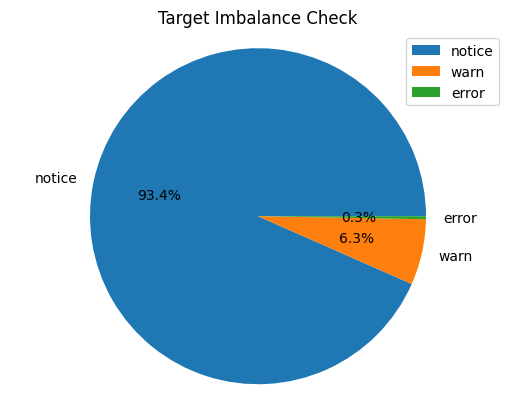

In [10]:
# check for imbalance
# Count the number of instances for each target value
target_counts = dataframe[target_feature].value_counts()

# Create a pie chart
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Target Imbalance Check')
plt.legend()
plt.show()

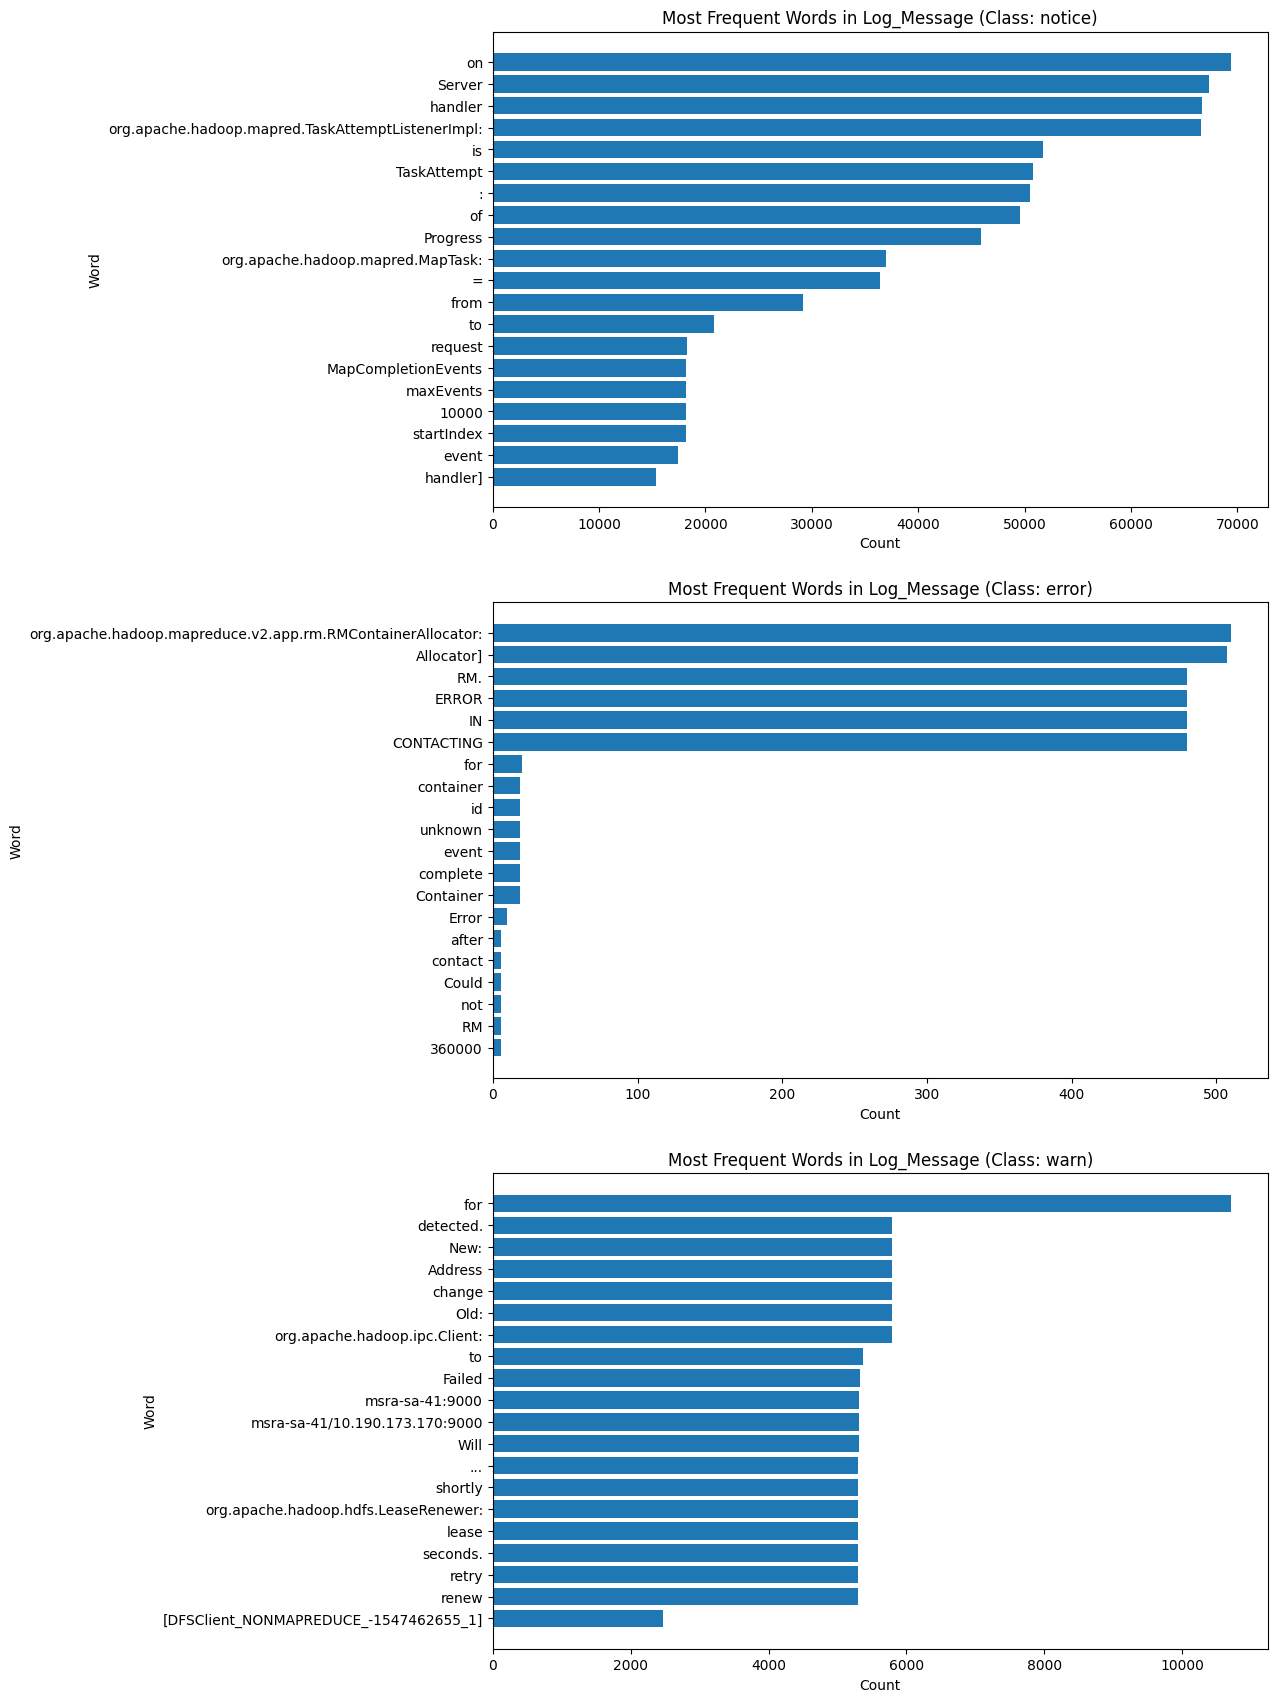

In [11]:
# Plot most frequent words per class
wordcount(dataframe, 'log_message', 'log_level', n=20)

# Preprocessing

## Functions

In [12]:
################################################################################
# Preprocessing
################################################################################

def text_preprocessing(
    dataframe
    ):

  '''
  Text Preprocessing Pipeline

  Input:
    dataframe

  Output:
    transformed dataframe
  '''

  categorical_features = list(dataframe.select_dtypes(exclude = np.number).columns)
  stop_words = set(stopwords.words('english'))
  lemmatizer = nltk.stem.WordNetLemmatizer()

  regex_patterns = {
    # basic patterns
    # remove url
    r'http\S+':                     ' ',
    # remove html tags
    r'<.*?>':                       ' ',
    # remove punctuation
    r'[^\w\s]':                     ' ',
    # remove numbers
    r'\d+':                         ' ',
    # remove multiple whitespace
    r'\s+':                         ' ',
    # remove newline
    r'\n':                          ' ',
    # remove underscore
    r'_':                           ' '
  }

  # # lowercase non-numeric features and convert to ASCII using unidecode
  for col in categorical_features:
    dataframe[col] = dataframe[col].apply(lambda x: unidecode(x.lower()) if type(x) == str else '')

  # fill empty cells
  for col in categorical_features:
    dataframe[col] = dataframe[col].fillna('')

  # re.sub regex patterns (dictionary defined in the cell above)
  for col in categorical_features:
    for key, value in regex_patterns.items():
      dataframe[col] = dataframe[col].apply(lambda x: re.sub(key,value,x))

  # drop duplicates after regex to speed up part-of-speech tagging
  dataframe = dataframe.drop_duplicates()

  # tokenize and remove stopwords
  for col in categorical_features:
    dataframe[col] = dataframe[col].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

  # part-of-speech tagging
  for col in categorical_features:
    dataframe[col] = dataframe.apply(lambda row: nltk.pos_tag(row[col]), axis=1)
    # wordnet mapping
    pos_tag_map = {
    'J': wordnet.ADJ,
    'V': wordnet.VERB,
    'N': wordnet.NOUN,
    'R': wordnet.ADV
    }

    dataframe[col] = dataframe.apply(lambda row: [(word, pos_tag_map.get(tag[0])) for word, tag in row[col]], axis=1)

  # lemmatizing
  for col in categorical_features:
    dataframe[col] = dataframe.apply(lambda row: [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in row[col]], axis=1)

  # combine again
  for col in categorical_features:
    dataframe[col] = dataframe[col].apply(lambda x: ' '.join(x))

  # fill empty cells after stopword removal
  for col in categorical_features:
    dataframe[col] = dataframe[col].fillna('')

  # final drop duplicates after all cleansing
  dataframe = dataframe.drop_duplicates()

  return dataframe

################################################################################
# Generate Bert-Embeddings
################################################################################

def bert_embeddings(data, max_length=100):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained("bert-base-uncased")
    # tokenize the text in the Series and get the attention masks
    tokenized = tokenizer(data.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=max_length)
    # extract pooled outputs
    with torch.no_grad():
      outputs = model(**tokenized).pooler_output.numpy()
    # return 2D numpy array
    return outputs

## Cleaning

In [13]:
dataframe_preprocessed = text_preprocessing(dataframe)

In [14]:
print(f'Text before cleaning:\n{dataframe.log_message.iloc[0]}\n')
print(f'Text after cleaning:\n{dataframe_preprocessed.log_message.iloc[0]}')

Text before cleaning:
org apache hadoop metrics impl metricsconfig loaded properties from hadoop metrics properties 

Text after cleaning:
org apache hadoop metric impl metricsconfig load property hadoop metric property


In [15]:
print('Samples before cleaning:')
display(dataframe['log_level'].value_counts())
print('Samples after cleaning:')
display(dataframe_preprocessed['log_level'].value_counts())

Samples before cleaning:


log_level
notice    168921
warn       11438
error        521
Name: count, dtype: int64

Samples after cleaning:


log_level
notice    652
warn       43
error      14
Name: count, dtype: int64

## Train/Test Split

In [16]:
def split_data(X, y, test_size=50, random_state=None):
    '''
    Splits the data into train and test sets

    Input:
      X = dataframe
      y = target feature
      test_size = size of test set
      random_state = random state for reproducibility

    Output:
      X_train = train set
      X_test = test set
      y_train = train labels
      y_test = test labels
    '''
    
    # notice & warn = 0, error = 1
    y = y.apply(lambda x: 0 if x in ['notice', 'warn'] else 1)

    # if enough outlier samples, split 50/50
    if len(y[y==1]) >= test_size//2:
      test_size = test_size // 2
      train_size = len(X[y==0]) - test_size
    # if not enough outlier samples, fill up test size with class 0
    else:
       test_size1 = len(y[y==1])
       test_size0 = 50 - test_size1
       train_size = len(X[y==0]) - test_size0

    # train dataset contains samples of class 0
    X_train = X[y==0].sample(train_size, random_state=random_state)
    y_train = y[X_train.index]

    # test dataset contains samples of class 1 and class 0
    X_test = pd.concat([
        X.drop(X_train.index).sample(test_size0, random_state=random_state),
        X[y==1].sample(test_size1, random_state=random_state)
        ])
    y_test = y[X_test.index]

    return X_train, X_test, y_train, y_test

In [17]:
data, target = dataframe_preprocessed['log_message'], dataframe_preprocessed['log_level']

xtrain, xtest, ytrain, ytest = split_data(data, target, test_size=50, random_state=1)

In [18]:
print(f'Observations xtrain: {xtrain.shape[0]}')
print(f'Observations xtest: {xtest.shape[0]}')

Observations xtrain: 659
Observations xtest: 50


In [19]:
print(f'Classes in train dataset:\n{np.unique(ytrain)}\n')
print(f'Classes in test dataset:\n{np.unique(ytest)}\n')
print(f'Outlier Percentage in test dataset:\n{round(ytest.mean()*100,2)}%')

Classes in train dataset:
[0]

Classes in test dataset:
[0 1]

Outlier Percentage in test dataset:
50.0%


## Embeddings (BERT)

In [20]:
xtrain_bert = bert_embeddings(xtrain)
xtest_bert = bert_embeddings(xtest)

# Modelling

## Approach 1: IsolationForest & XGBoost

ConcreteML lacks support for "One Class Classification". To address this limitation, a potential workaround involves initially training an IsolationForest from the Scikit-learn library to generate anomaly labels. These labels can then serve as the classifier target for training an XGBClassifier, which can operate in conjunction with ConcreteML, allowing for the utilization of homomorphic encryption while accommodating the absence of direct support for One Class Classification within ConcreteML.
<br></br>

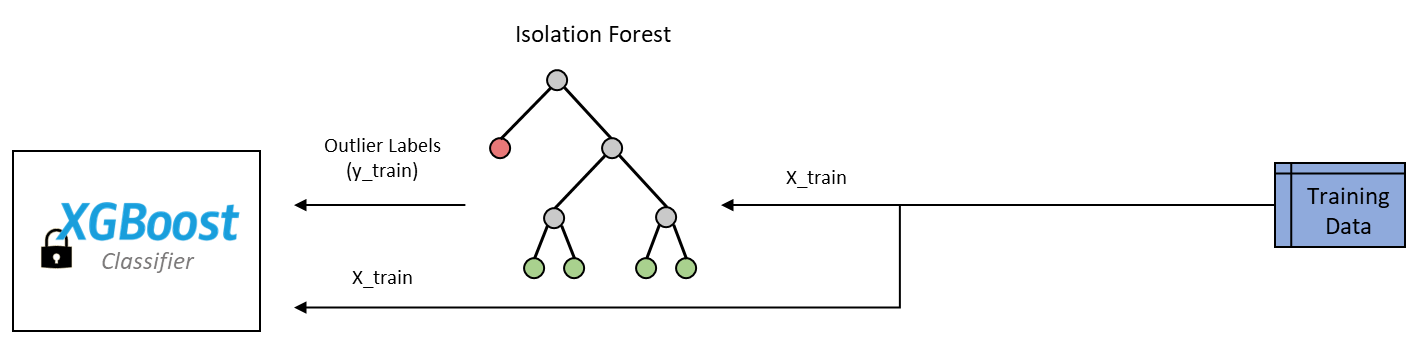

### Functions

In [21]:
################################################################################
# XGBoost Anomaly Detector
################################################################################

class AnomalyDetector:
  def __init__(self, random_state=None):
    self.random_state = random_state
    self.xgb = None
    self.iso = None
    self.log = {
        'train':       None,
        'evaluate_total':  None,
        'evaluate_sample': None
      }

  def train(self, X):
    # training
    start_time = time.time()
    self.iso = IsolationForest(random_state=self.random_state).fit(X)
    ytrain_iso = np.where(self.iso.predict(X) == -1, 1, 0)
    self.xgb = XGBClassifier(random_state=self.random_state).fit(X, ytrain_iso)
    self.log['train'] = time.time() - start_time
    return self

  def evaluate(self, X, model='xgb'):
    if model=='xgb':
      # predict
      start_time = time.time()
      ypred = self.xgb.predict(X)
      self.log['evaluate_total'] = time.time() - start_time
      self.log['evaluate_sample'] = self.log['evaluate_total']/len(X)
      return ypred
    elif model=='iso':
      return np.where(self.iso.predict(X) == -1, 1, 0)

################################################################################
# Concrete Anomaly Detector
################################################################################

class ConcreteAnomalyDetector:
  def __init__(self, n_bits=2, random_state=None):
    self.n_bits = n_bits
    self.random_state = random_state
    self.xgb = None
    self.iso = None
    self.fhe_circuit = None
    self.log = {
        'train':       None,
        'compile':        None,
        'keygen':         None,
        'evaluate_total':  None,
        'evaluate_sample': None
      }

  def train(self, X):
    # training
    start_time = time.time()
    self.iso = IsolationForest(random_state=self.random_state).fit(X)
    ytrain_iso = np.where(self.iso.predict(X) == -1, 1, 0)
    self.xgb = ConcreteXGBClassifier(n_bits=self.n_bits, random_state=self.random_state).fit(X, ytrain_iso)
    self.log['train'] = time.time() - start_time
    # compile
    start_time = time.time()
    self.fhe_circuit = self.xgb.compile(X[:100])
    self.log['compile'] = time.time() - start_time
    return self

  def evaluate(self, X, fhe='simulate'):
    # key generation
    start_time = time.time()
    self.fhe_circuit.keygen(force=True)
    self.log['keygen'] = time.time() - start_time
    # predict
    start_time = time.time()
    ypred = [self.xgb.predict(X[[i], :], fhe=fhe)[0] for i in tqdm(range(X.shape[0]))]
    self.log['evaluate_total'] = time.time() - start_time
    self.log['evaluate_sample'] = self.log['evaluate_total']/len(X)
    return ypred

### XGBoost

In [22]:
ad = AnomalyDetector(random_state=1).train(xtrain_bert)

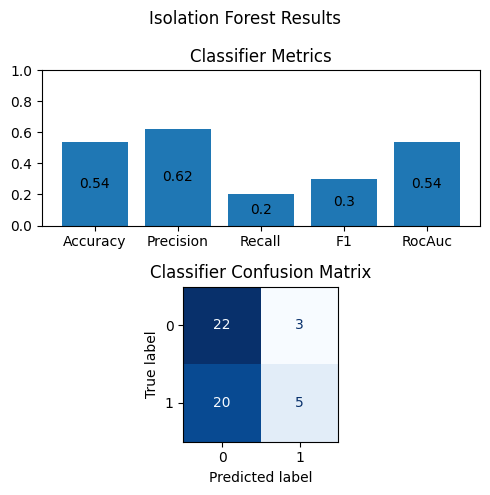

In [23]:
# predict and plot Isolation Forest results
ypred_iso = ad.evaluate(xtest_bert, model='iso')
plot_classification_metrics(ytest, ypred_iso, plot_title='Isolation Forest Results')

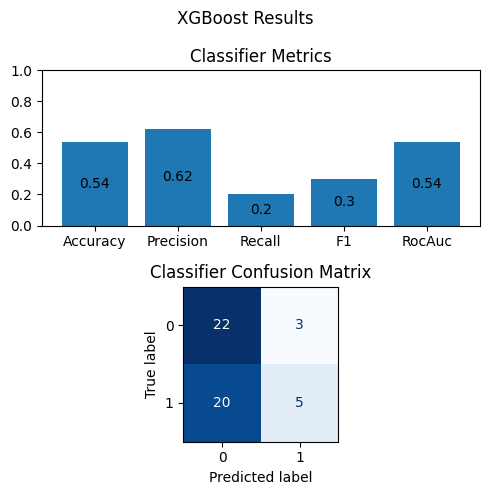

In [24]:
# predict and plot XGBoost results
ypred_xgb = ad.evaluate(xtest_bert, model='xgb')
plot_classification_metrics(ytest, ypred_xgb, plot_title='XGBoost Results')

In [25]:
ad_results = pd.DataFrame(ad.log, index=[0])
ad_results

,train,evaluate_total,evaluate_sample
0,1.424701,0.003529,0.000071


### Concrete

In [26]:
results = {'n_bits': [], 'y_pred': [], 'times': [], 'metrics': []}

for n_bits in range(2,7):

  cad = ConcreteAnomalyDetector(n_bits=n_bits, random_state=1)
  y_pred = cad.train(xtrain_bert).evaluate(xtest_bert, fhe='simulate')
  metrics = {
      'accuracy':   accuracy_score(ytest, y_pred),
      'precision':  precision_score(ytest, y_pred),
      'recall':     recall_score(ytest, y_pred),
      'f1':         f1_score(ytest, y_pred)
  }

  results['n_bits'].append(n_bits)
  results['y_pred'].append(y_pred)
  results['times'].append(cad.log)
  results['metrics'].append(metrics)

100%|██████████| 50/50 [00:00<00:00, 63.08it/s]


########################### bits = 2 ###########################


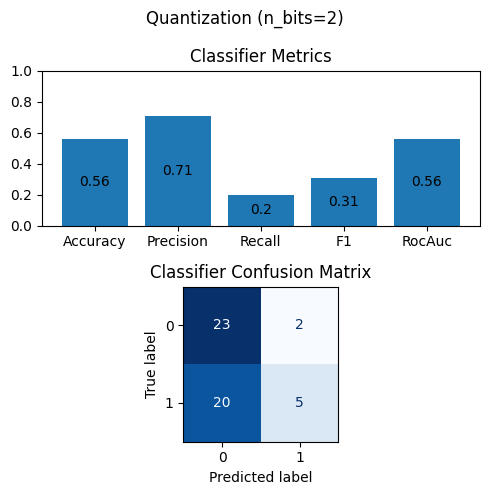

########################### bits = 3 ###########################


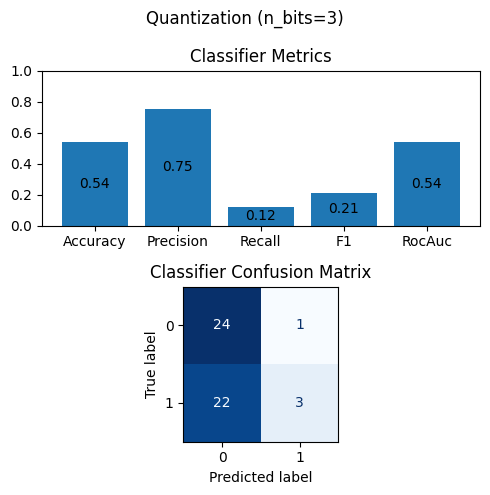

########################### bits = 4 ###########################


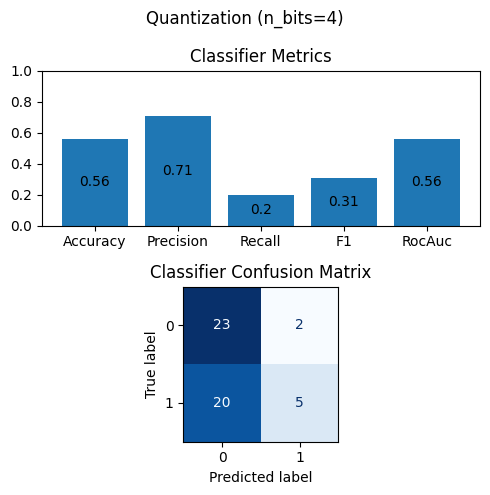

########################### bits = 5 ###########################


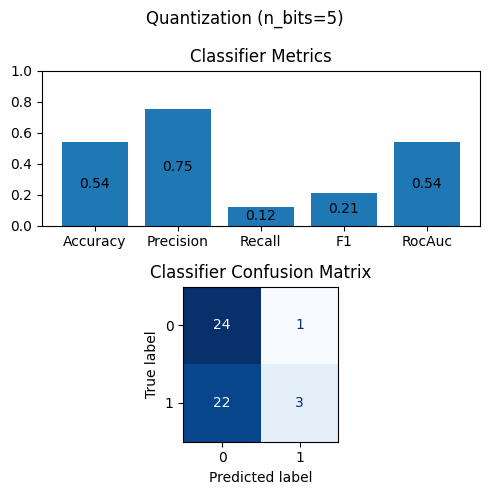

########################### bits = 6 ###########################


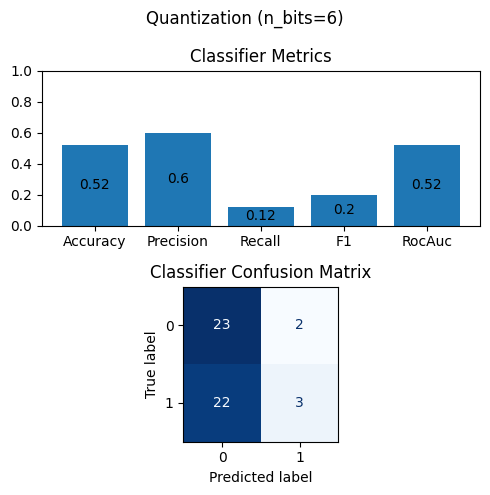

In [27]:
for preds, bits in zip(results['y_pred'], results['n_bits']):
  print(f'########################### bits = {bits} ###########################')
  plot_classification_metrics(ytest, preds, plot_title=f'Quantization (n_bits={bits})')

In [28]:
cad_results = pd.concat([pd.DataFrame.from_records(results['times']), pd.DataFrame.from_records(results['metrics'])], axis=1)
cad_results.insert(0, 'n_bits', results['n_bits'])
cad_results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,4.406139,4.209671,4.015342,0.858497,0.017170,0.56,0.714286,0.20,0.312500
1,3,2.857091,0.373809,2.808267,0.824483,0.016490,0.54,0.750000,0.12,0.206897
2,4,3.137992,0.531371,6.347875,0.819947,0.016399,0.56,0.714286,0.20,0.312500
3,5,2.969043,0.502055,17.904957,0.768015,0.015360,0.54,0.750000,0.12,0.206897
4,6,2.873989,0.437696,70.198900,0.795206,0.015904,0.52,0.600000,0.12,0.200000


## Approach 2: Autoencoder

The idea behind an _Autoencoder_ is to constrain a neural network with a bottleneck, compelling it to compress input data into a reduced representation and then reconstruct the original input. The core objective is to reproduce the input accurately. By comparing the starting input with what the autoencoder rebuilds, we can pinpoint anomalies by noticing where errors in the recreation process are substantially higher.
<br></br>

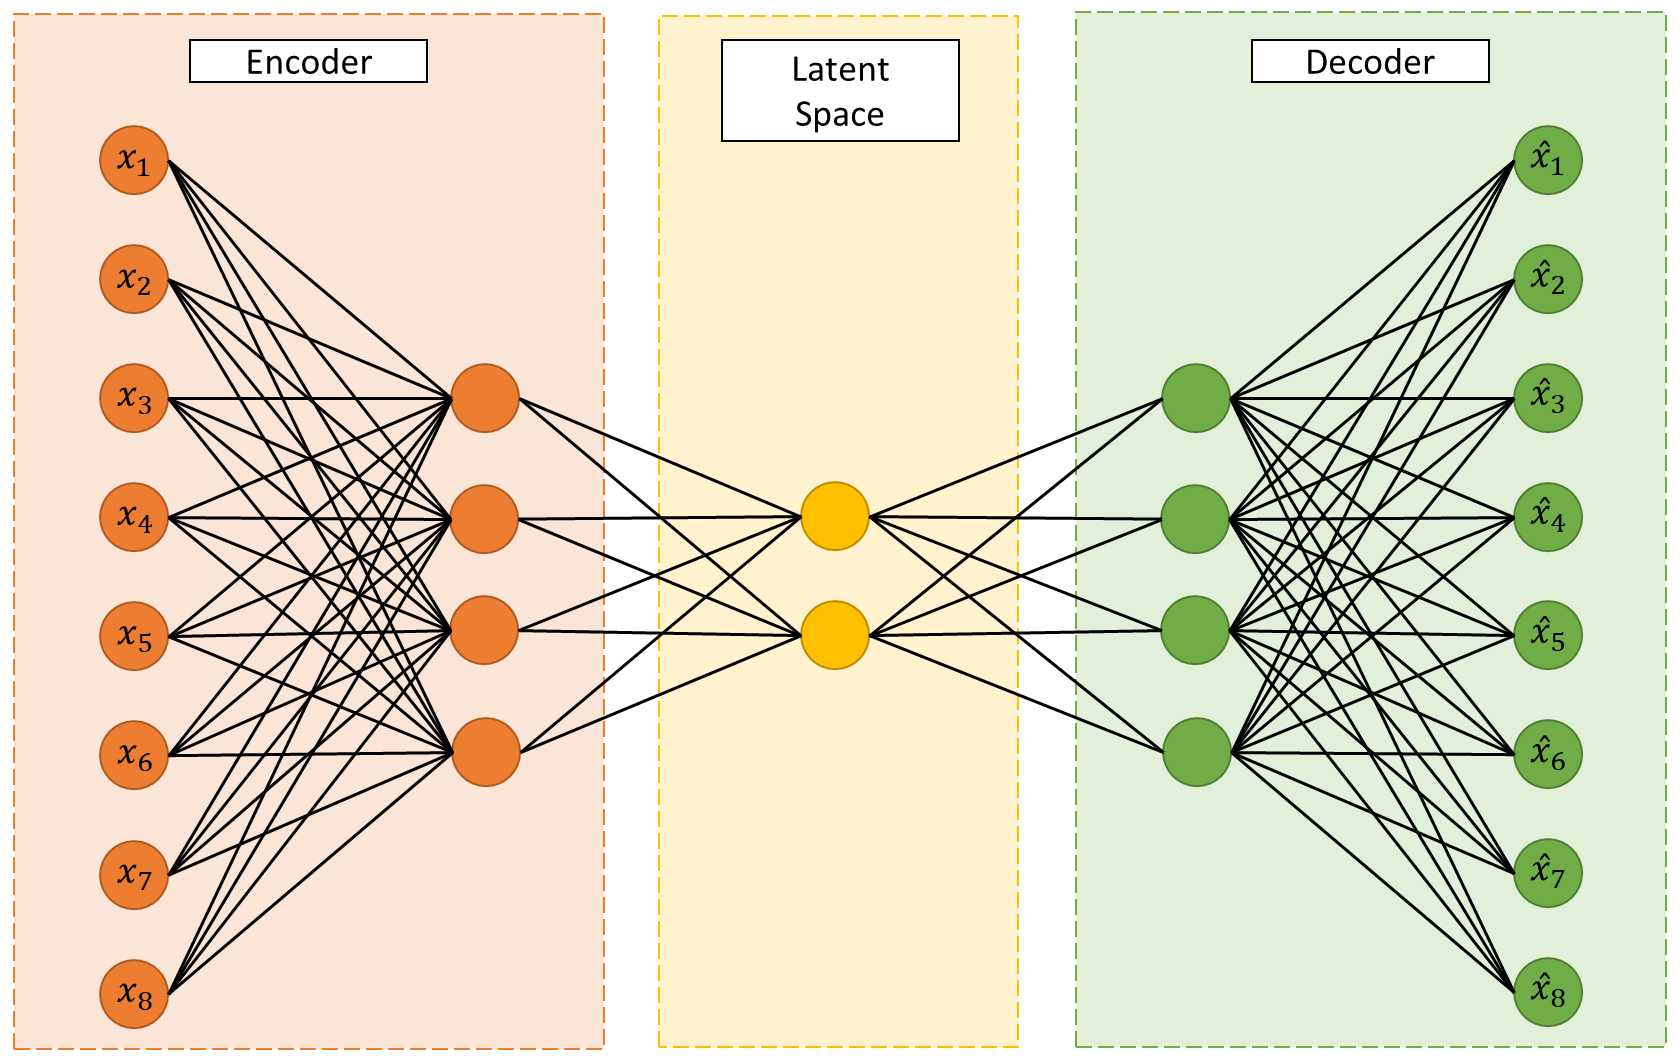

### Functions

In [29]:
################################################################################
# PyTorch Autoencoder
################################################################################

class TorchAutoencoder(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.threshold = None
        self.log = {
            'train': None,
            'evaluate_total': None,
            'evaluate_sample': None
        }

    def train(self, X, epochs=20, verbose=True):
        X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
        self.model = self.model.train()
        # train model
        start_time = time.time()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            ypred = self.model(X_tensor)
            loss = self.criterion(ypred, X_tensor)
            loss.backward()
            self.optimizer.step()
            print(f'Epoch: {epoch+1}\tLoss: {loss.item():.4f}') if verbose is True else None
        self.log['train'] = time.time() - start_time
        # calculate threshold
        self.model = self.model.eval()
        with torch.no_grad():
            reconstructed_data = self.model(X_tensor)
        reconstruction_error = torch.mean((X_tensor - reconstructed_data)**2, axis=1)
        self.threshold = np.percentile(reconstruction_error, 90)
        return self

    def evaluate(self, X):
        X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
        # evaluate model
        start_time = time.time()
        with torch.no_grad():
            reconstructed_data = self.model(X_tensor)
        reconstruction_error = torch.mean((X_tensor - reconstructed_data)**2, axis=1)
        ypred = np.where(reconstruction_error > self.threshold, 1, 0)
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X_tensor.shape[0]
        return ypred

################################################################################
# Concrete Autoencoder
################################################################################

class ConcreteAutoencoder(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.threshold = None
        self.fhe_module = None
        self.log = {
            'train': None,
            'compile': None,
            'keygen': None,
            'evaluate_total': None,
            'evaluate_sample': None
        }

    def train(self, X, n_bits, epochs=20, verbose=True):
        X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
        self.model = self.model.train()
        # train model
        start_time = time.time()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            ypred = self.model(X_tensor)
            loss = self.criterion(ypred, X_tensor)
            loss.backward()
            self.optimizer.step()
            print(f'Epoch: {epoch+1}\tLoss: {loss.item():.4f}') if verbose is True else None
        self.log['train'] = time.time() - start_time
        # calculate threshold
        self.model = self.model.eval()
        with torch.no_grad():
            reconstructed_data = self.model(X_tensor)
        reconstruction_error = torch.mean((X_tensor - reconstructed_data)**2, axis=1)
        self.threshold = np.percentile(reconstruction_error, 90)
        # compile
        start_time = time.time()
        self.fhe_module = compile_brevitas_qat_model(self.model, X_tensor[:100], rounding_threshold_bits=n_bits)
        self.log['compile'] = time.time() - start_time
    	  # check-up
        bitwidth = self.fhe_module.fhe_circuit.graph.maximum_integer_bit_width()
        print('max. bithwidth (16) exceeded!') if bitwidth > 16 else None
        return self

    def evaluate(self, X, fhe='simulate'):
        X_np = np.array(X)
        # key generation
        start_time = time.time()
        self.fhe_module.fhe_circuit.keygen(force=True)
        self.log['keygen'] = time.time() - start_time
        # evaluate model
        start_time = time.time()
        ypred = [
            1 if np.mean((self.fhe_module.forward(X_np[[i], :], fhe=fhe) - X_np[[i], :])**2, axis=1) > self.threshold
            else 0
            for i in tqdm(range(X_np.shape[0]))
            ]
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X_np.shape[0]
        return ypred

### Pytorch

In [30]:
input_dim = xtrain_bert.shape[1]
encoding_dim = input_dim // 10

In [31]:
torch_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, encoding_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(encoding_dim, input_dim),
    torch.nn.Sigmoid()
)

Epoch: 1	Loss: 0.6063
Epoch: 2	Loss: 0.5927
Epoch: 3	Loss: 0.5798
Epoch: 4	Loss: 0.5645
Epoch: 5	Loss: 0.5471
Epoch: 6	Loss: 0.5282
Epoch: 7	Loss: 0.5081
Epoch: 8	Loss: 0.4873
Epoch: 9	Loss: 0.4661
Epoch: 10	Loss: 0.4448
Epoch: 11	Loss: 0.4236
Epoch: 12	Loss: 0.4029
Epoch: 13	Loss: 0.3827
Epoch: 14	Loss: 0.3634
Epoch: 15	Loss: 0.3449
Epoch: 16	Loss: 0.3274
Epoch: 17	Loss: 0.3110
Epoch: 18	Loss: 0.2957
Epoch: 19	Loss: 0.2816
Epoch: 20	Loss: 0.2687


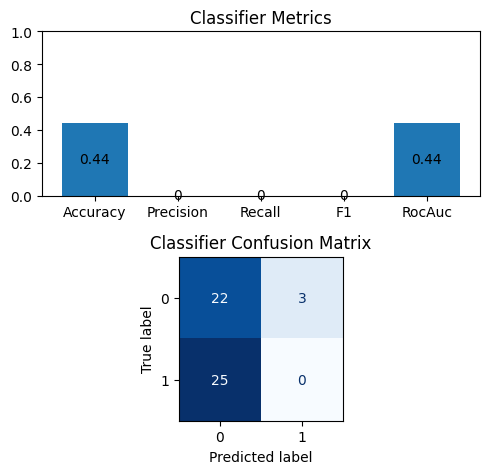

In [32]:
tae = TorchAutoencoder(model=torch_model).train(xtrain_bert)
ypred_tae = tae.evaluate(xtest_bert)
plot_classification_metrics(ytest, ypred_tae)

In [33]:
tae_results = pd.DataFrame(tae.log, index=[0])
tae_results

,train,evaluate_total,evaluate_sample
0,0.599663,0.000483,0.00001


### Concrete

In [ ]:
input_dim = xtrain_bert.shape[1]
encoding_dim = input_dim // 10

In [ ]:
results = {'n_bits': [], 'y_pred': [], 'times': [], 'metrics': []}

for n_bits in range(2,7):

  brevitas_model = torch.nn.Sequential(
    brevitas.nn.QuantIdentity(bit_width=n_bits, return_quant_tensor=True),
    brevitas.nn.QuantLinear(input_dim, encoding_dim, bias=True, weight_bit_width=n_bits),
    brevitas.nn.QuantReLU(),
    brevitas.nn.QuantLinear(encoding_dim, input_dim, bias=True, weight_bit_width=n_bits),
    brevitas.nn.QuantSigmoid()
  )

  cae = ConcreteAutoencoder(brevitas_model)
  y_pred = cae.train(xtrain_bert, n_bits=n_bits, verbose=False).evaluate(xtest_bert, fhe='simulate')
  metrics = {
      'accuracy':   accuracy_score(ytest, y_pred),
      'precision':  precision_score(ytest, y_pred),
      'recall':     recall_score(ytest, y_pred),
      'f1':         f1_score(ytest, y_pred)
  }

  results['n_bits'].append(n_bits)
  results['y_pred'].append(y_pred)
  results['times'].append(cae.log)
  results['metrics'].append(metrics)

In [ ]:
for preds, bits in zip(results['y_pred'], results['n_bits']):
  print(f'########################### bits = {bits} ###########################')
  plot_classification_metrics(ytest, preds, plot_title=f'Quantization (n_bits={bits})')

In [ ]:
cae_results = pd.concat([pd.DataFrame.from_records(results['times']), pd.DataFrame.from_records(results['metrics'])], axis=1)
cae_results.insert(0, 'n_bits', results['n_bits'])
cae_results